<a href="https://colab.research.google.com/github/ARoma2000/analyst-portfolio/blob/main/Analysis_of_bank_customer_attrition_2024_07_en_pynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



## **Анализ оттока клиентов банка**

**(поиск инсайтов, составление рекомендаций стейкхолдерам, построение модели оттока)**

---------------------------------------------------------------------------


***Подключение библиотек, необходимых в данной работе***

In [ ]:
import pandas as pd
import requests
from io import StringIO
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score, accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

***Загрузка данных из CSV-файла по ссылке***



In [ ]:
# Для исследования был взят датасет “Churn for Bank Customers” со статистикой операций клиентов банка - https://www.kaggle.com/datasets/mathchi/churn-for-bank-customers
# Для удобства работы файл сохранен на Google Drive - https://drive.google.com/file/d/1OX0z1UBQkcuKmJkRavE7MNMpG2AcnA9-/view?usp=sharing
# ID файла на Google Drive
file_id = '1OX0z1UBQkcuKmJkRavE7MNMpG2AcnA9-'
# Формирование ссылки на скачивание
download_url = f'https://drive.google.com/uc?export=download&id={file_id}'

# Получение данных по ссылке
response = requests.get(download_url)

# Проверка успешности запроса
if response.status_code == 200:
    # Преобразование текста в объект StringIO
    csv_data = StringIO(response.text)

    # Загрузка данных в DataFrame
    df = pd.read_csv(csv_data)
else:
    print(f"Не удалось загрузить файл, статус код: {response.status_code}")

# Вывод первых 5 строк DataFrame
df.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


# ***Разведочный анализ данных или Exploratory Data Analysis (EDA)***

***Предваритиельный анализ данных на пропуски и аномалии***

***Описание основных статистических характеристик***

In [ ]:
# см типы данных и пропуски
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           10000 non-null  int64  
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(2), int64(9), object(3)
memory usage: 1.1+ MB


*Видим, что пропусков нет, а типы данных адекватны.*

RowNumber: Номер строки — соответствует номеру записи (строки) и не влияет на выходные данные.

CustomerId: Идентификатор клиента — содержит случайные значения и не влияет на уход клиента из банка.

Surname: Фамилия — фамилия клиента не влияет на их решение покинуть банк.

CreditScore: Кредитный рейтинг — может влиять на отток клиентов, так как клиенты с более высоким кредитным рейтингом менее склонны покидать банк.

Geography: География — местоположение клиента может повлиять на их решение покинуть банк.

Gender: Пол — интересно исследовать, играет ли роль пол клиента в его уходе из банка.

Age: Возраст — это, безусловно, имеет значение, так как пожилые клиенты менее склонны покидать банк, чем молодые.

Tenure: Стаж — относится к количеству лет, в течение которых клиент является клиентом банка. Обычно старшие клиенты более лояльны и менее склонны покидать банк.

Balance: Баланс — также очень хороший индикатор оттока клиентов, так как люди с более высоким балансом на счетах менее склонны покидать банк по сравнению с теми, у кого баланс ниже.

NumOfProducts: Количество продуктов — относится к количеству продуктов, которые клиент приобрел через банк.

HasCrCard: Наличие кредитной карты — указывает, есть ли у клиента кредитная карта. Этот столбец также имеет значение, так как люди с кредитной картой менее склонны покидать банк.

IsActiveMember: Активный клиент — активные клиенты менее склонны покидать банк.

EstimatedSalary: Предполагаемая зарплата — как и с балансом, люди с более низкой зарплатой более склонны покидать банк по сравнению с теми, у кого зарплата выше.

Exited: Уход клиента — указывает, покинул ли клиент банк.


In [ ]:
# Список уникальных значений Gender
unique_Gender = df['Gender'].unique()
print(unique_Gender)

['Female' 'Male']


In [ ]:
# Список уникальных значений Geography
unique_Geography = df['Geography'].unique()
print(unique_Geography)

['France' 'Spain' 'Germany']


In [ ]:
# Список уникальных значений Exited
unique_Exited = df['Exited'].unique()
print(unique_Exited)

[1 0]


In [ ]:
# Подсчет количества уникальных клиентов
unique_clients_count = df['CustomerId'].nunique()
print(unique_clients_count)

10000


*Видим, что значения колонок Gender, Geography, Exited адеквтны. В датасете 1000 строк в отношении 1000 уникальных клтентов, т.е. дублирующих строк нет.*

*Соответственно никаких специальных подготовительных работ(очистка или замена значений) перед анализом можно не осуществлять.*

In [ ]:
# Основные статистические характеристики
df.describe()

,RowNumber,CustomerId,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,10000.00000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
mean,5000.50000,1.569094e+07,650.528800,38.921800,5.012800,76485.889288,1.530200,0.70550,0.515100,100090.239881,0.203700
std,2886.89568,7.193619e+04,96.653299,10.487806,2.892174,62397.405202,0.581654,0.45584,0.499797,57510.492818,0.402769
min,1.00000,1.556570e+07,350.000000,18.000000,0.000000,0.000000,1.000000,0.00000,0.000000,11.580000,0.000000
25%,2500.75000,1.562853e+07,584.000000,32.000000,3.000000,0.000000,1.000000,0.00000,0.000000,51002.110000,0.000000
50%,5000.50000,1.569074e+07,652.000000,37.000000,5.000000,97198.540000,1.000000,1.00000,1.000000,100193.915000,0.000000
75%,7500.25000,1.575323e+07,718.000000,44.000000,7.000000,127644.240000,2.000000,1.00000,1.000000,149388.247500,0.000000
max,10000.00000,1.581569e+07,850.000000,92.000000,10.000000,250898.090000,4.000000,1.00000,1.000000,199992.480000,1.000000


***Изучение распределения целевой переменной Exited.***

***Исследование корреляций между признаками и целевой переменной.***

***Визуализация данных для поиска инсайтов.***


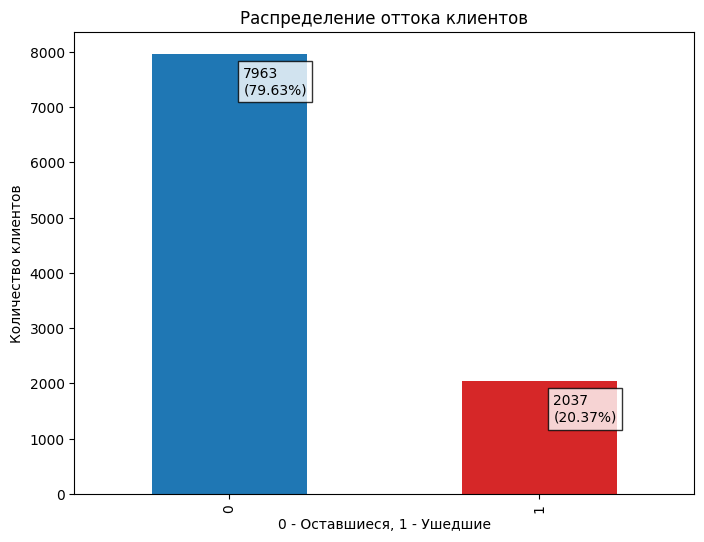

In [ ]:
# Сравнительное распределение по возрасту ушедших и оставшихся клиентов

# Подготовка данных для распределения оттока
exit_distribution = df.groupby('Exited').size()

# Построение bar plot
ax = exit_distribution.plot(kind='bar', color=['tab:blue', 'tab:red'], figsize=(8, 6))
plt.title('Распределение оттока клиентов')
plt.xlabel('0 - Оставшиеся, 1 - Ушедшие')
plt.ylabel('Количество клиентов')


# Добавление аннотаций для наглядности
total = exit_distribution.sum()
for i, value in exit_distribution.items():
    percentage = value / total * 100
    ax.annotate(f'{value}\n({percentage:.2f}%)',
                (i, value),
                ha='left',
                va='center',
                fontsize=10,
                color='black',
                xytext=(10, -20),  # Сдвиг вверх от границы
                textcoords='offset points',
                bbox=dict(facecolor='white', alpha=0.8, edgecolor='black'))  # Фон для текста
plt.show()

*Гистограмма показывает, что из 1000 клиентов за рассматриваемый период осталось 79,63%, ушло - 20,37%.*

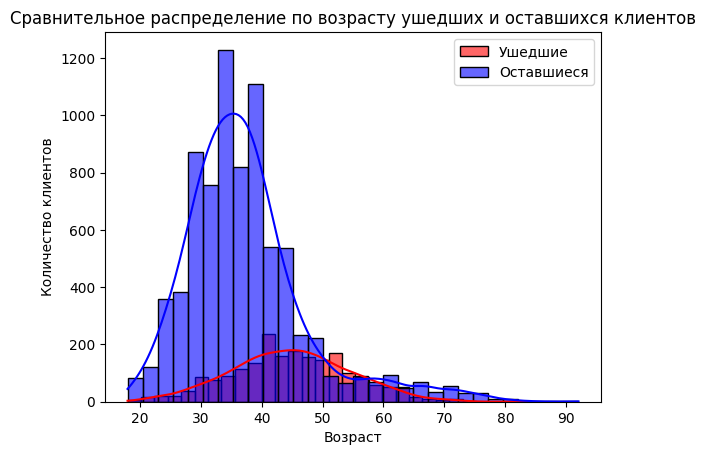

In [ ]:
# Сравнительное распределение по возрасту ушедших и оставшихся клиентов
sns.histplot(df[df['Exited'] == 1]['Age'], bins=30, kde=True, color='red', label='Ушедшие', alpha=0.6)
sns.histplot(df[df['Exited'] == 0]['Age'], bins=30, kde=True, color='blue', label='Оставшиеся', alpha=0.6)
plt.title('Сравнительное распределение по возрасту ушедших и оставшихся клиентов')
plt.xlabel('Возраст')
plt.ylabel('Количество клиентов')
plt.legend()
plt.show()

*Видим, что большее количество действующих клиентов банка находятся в возрасте примерно от 28 до 45 лет, а существенная доля тех, кто принял решение уйти из банка, находятся в возрасте примерно от 40 до 50 лет.*

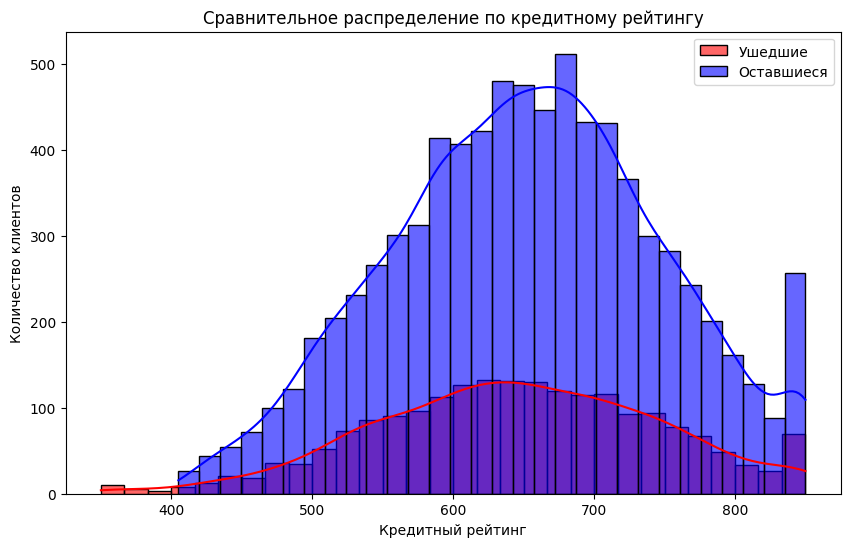

In [ ]:
# Сравнительное распределение по кредитному рейтингу
plt.figure(figsize=(10, 6))
sns.histplot(df[df['Exited'] == 1]['CreditScore'], bins=30, kde=True, color='red', label='Ушедшие', alpha=0.6)
sns.histplot(df[df['Exited'] == 0]['CreditScore'], bins=30, kde=True, color='blue', label='Оставшиеся', alpha=0.6)
plt.title('Сравнительное распределение по кредитному рейтингу')
plt.xlabel('Кредитный рейтинг')
plt.ylabel('Количество клиентов')
plt.legend()
plt.show()

*Видим, что средний рейтинг ушедших в среднем похож, но все же немного ниже.*

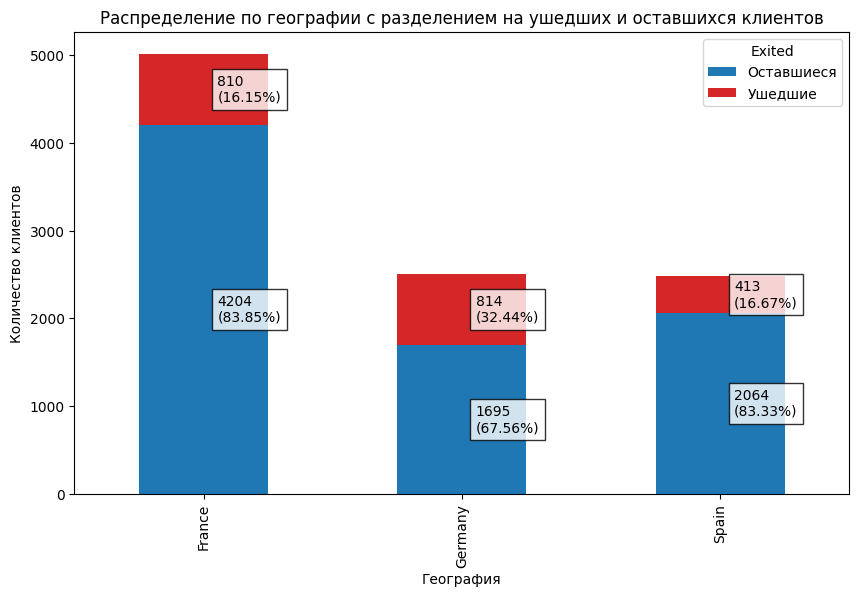

In [ ]:
# Сравнительное распределение по географии

# Подготовка данных
geo_exited = df.groupby(['Geography', 'Exited']).size().unstack(fill_value=0)

# Построение stacked bar plot
ax = geo_exited.plot(kind='bar', stacked=True, figsize=(10, 6), color=['tab:blue', 'tab:red'])
plt.title('Распределение по географии с разделением на ушедших и оставшихся клиентов')
plt.xlabel('География')
plt.ylabel('Количество клиентов')
plt.legend(title='Exited', labels=['Оставшиеся', 'Ушедшие'])


# Добавление аннотаций для наглядности
for country_idx, (country, group) in enumerate(geo_exited.iterrows()):
    total = group.sum()
    cumulative_height = 0
    for status, color in zip(group.index, ['tab:blue', 'tab:red']):
        height = group[status]
        if height > 0:
            # Вычисление позиции для аннотации
            x_position = country_idx
            y_position = cumulative_height + height / 2  # Средина текущего сегмента
            percentage = height / total * 100
            label_text = f'{height}\n({percentage:.2f}%)'
            ax.annotate(label_text,
                        (x_position, y_position),
                        ha='left',
                        va='center',
                        fontsize=10,
                        color='black',
                        xytext=(10, 0),  # Сдвиг вправо от границы
                        textcoords='offset points',
                        bbox=dict(facecolor='white', alpha=0.8, edgecolor='black'))  # Фон для текста
            cumulative_height += height

plt.show()

*Гистограмма показывает, что большее количество клиентов располагается во Франции и доля ушедших клиентов там составляет ~16%. Количество клиентов как в Германии, так и в Испании в два раза меньше, чем во Франции, но отток разный ( ~16% в Испании и ~32% в Германии).*


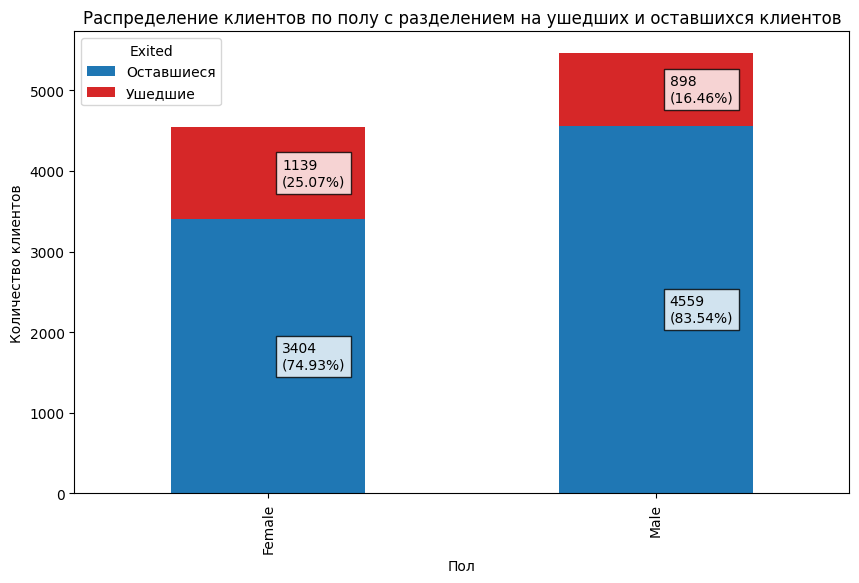

In [ ]:
# Сравнительное распределение по полу

# Подготовка данных
gender_exited = df.groupby(['Gender', 'Exited']).size().unstack(fill_value=0)

# Построение stacked bar plot
ax = gender_exited.plot(kind='bar', stacked=True, figsize=(10, 6), color=['tab:blue', 'tab:red'])
plt.title('Распределение клиентов по полу с разделением на ушедших и оставшихся клиентов')
plt.xlabel('Пол')
plt.ylabel('Количество клиентов')
plt.legend(title='Exited', labels=['Оставшиеся', 'Ушедшие'])

# Добавление аннотаций для наглядности
for gender_idx, (gender, group) in enumerate(gender_exited.iterrows()):
    total = group.sum()
    cumulative_height = 0
    for status, color in zip(group.index, ['tab:blue', 'tab:red']):
        height = group[status]
        if height > 0:
            # Вычисление позиции для аннотации
            x_position = gender_idx
            y_position = cumulative_height + height / 2  # Средина текущего сегмента
            percentage = height / total * 100
            label_text = f'{height}\n({percentage:.2f}%)'
            ax.annotate(label_text,
                        (x_position, y_position),
                        ha='left',
                        va='center',
                        fontsize=10,
                        color='black',
                        xytext=(10, 0),  # Сдвиг вправо от границы
                        textcoords='offset points',
                        bbox=dict(facecolor='white', alpha=0.8, edgecolor='black'))  # Фон для текста
            cumulative_height += height

plt.show()

*Гистограмма демонстрирует, что общая доля клиентов мужчин больше и что они реже уходят.*

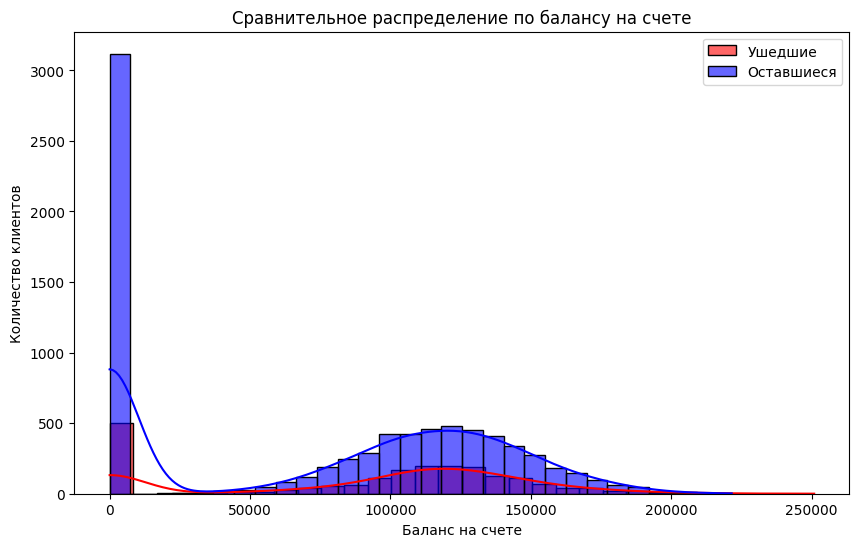

In [ ]:
# Сравнительное распределение по балансу на счете

plt.figure(figsize=(10, 6))
sns.histplot(df[df['Exited'] == 1]['Balance'], bins=30, kde=True, color='red', label='Ушедшие', alpha=0.6)
sns.histplot(df[df['Exited'] == 0]['Balance'], bins=30, kde=True, color='blue', label='Оставшиеся', alpha=0.6)
plt.title('Сравнительное распределение по балансу на счете')
plt.xlabel('Баланс на счете')
plt.ylabel('Количество клиентов')
plt.legend()
plt.show()

*Распределения баланса ушедших и оставшихся очень похожи.*

***Подготовка данных для корреляционной матрицы***

In [ ]:
df.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [ ]:
# Удаление столбцов, ненужных для корреляционной матрицы
df_corr = df.drop(['RowNumber', 'CustomerId', 'Surname'], axis=1)

# Преобразование категориальных переменных в числовые с помощью one-hot encoding
df_corr = pd.get_dummies(df_corr, columns=['Geography', 'Gender'], drop_first=True)

df_corr.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_Germany,Geography_Spain,Gender_Male
0,619,42,2,0.00,1,1,1,101348.88,1,False,False,False
1,608,41,1,83807.86,1,0,1,112542.58,0,False,True,False
2,502,42,8,159660.80,3,1,0,113931.57,1,False,False,False
3,699,39,1,0.00,2,0,0,93826.63,0,False,False,False
4,850,43,2,125510.82,1,1,1,79084.10,0,False,True,False


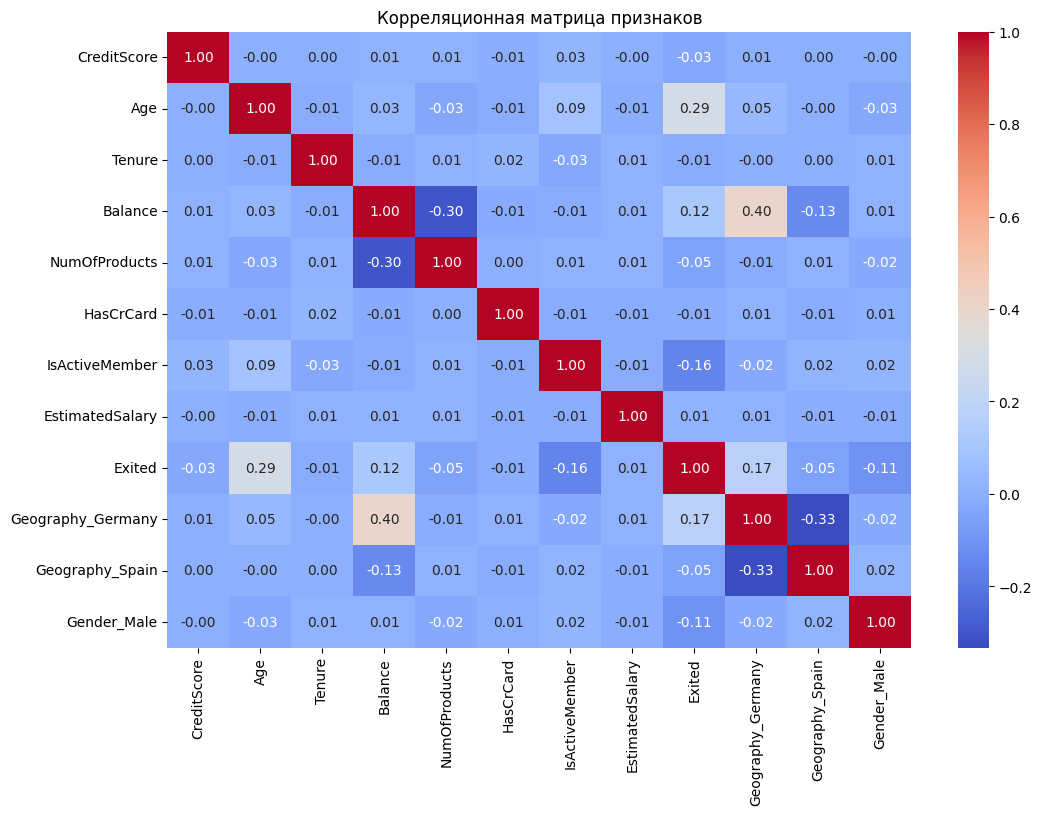

In [ ]:
# Расчет корреляционной матрицы
corr_matrix = df_corr.corr()

# Визуализация корреляционной матрицы
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Корреляционная матрица признаков')
plt.show()

**Анализ корреляционной матрицы (корреляция с целевой переменной Exited):**

Age: Корреляция с Exited  0.29 -> c возрастом клиенты могут чаще покидать банк.

Geography_Germany: Корреляция с Exited 0.17 ->  клиенты из Германии чаще уходят.

Balance: Корреляция с Exited  0.12 ->  клиенты с высоким балансом реже уходят, но корреляция слабая.

IsActiveMember: Корреляция с Exited  -0.16 (отрицательная) -> активные клиенты реже покидают банк.

Другие признаки имеют еще меньшую корреляцию с целевой переменной -> имеют еще меньшую значимость в контексте оттока клиентов.


Нет высоких корреляций (больше 0.8) между признаками -> низкий уровень мультиколлинеарности -> можно более точно оценить важность каждого признака

# ***Рекомендации на основе анализа EDA***

На основе анализа корреляционной матрицы можно сделать следующие выводы и рекомендации:

**Возраст клиентов:**

Поскольку возраст является значимым фактором, рекомендуется проводить целевые кампании для удержания клиентов определенного возраста. Возможно, стоит предложить специальные продукты и услуги для различных возрастных групп.

**Географическое расположение:**

Высокий уровень оттока клиентов в Германии (32%) по сравнению с другими регионами, такими как Франция (16%) и Испания (16%).
Возможно, стоит провести локальные опросы или исследования для выявления специфических особенностей, которые могут влиять на уровень оттока в Германии, и разработать отдельные стратегии удержания для клиентов из этого региона.


**Пол клиентов:**

Так как мужчины составляют большую долю клиентов и имеют меньшую вероятность ухода по сравнению с женщинами, можно рассмотреть возможность создания специализированных предложений и акций для женщин, чтобы улучшить их удержание. Анализ причин более высокой склонности к уходу среди женщин может помочь в разработке эффективных стратегий по удержанию.


**Баланс на счету:**

Несмотря на слабую корреляцию, клиенты с высоким балансом менее склонны к оттоку. Возможно, стоит разработать программы лояльности или привилегии для клиентов с высоким балансом, чтобы еще больше уменьшить вероятность их ухода.

**Активность клиентов:**

Активные клиенты реже уходят. Это указывает на важность вовлеченности клиентов. Можно предложить программы поощрения за активное использование банковских услуг.

**Другие факторы:**

Такие признаки как EstimatedSalary, Tenure, NumOfProducts и HasCrCard имеют низкую корреляцию с оттоком клиентов и, возможно, менее важны для прогнозирования оттока.

# ***Построение модели для прогнозирования оттока клиентов***

Целью построения модели логистической регрессии в данной задаче является прогнозирование вероятности ухода клиентов из банка (оттока).

***Подготовка данных для моделирования***

In [ ]:
# Возьмем в работу df_corr - это ранее уточненный датафрейм без личних столбцов и с преобразоваными категориальными переменными в числовые
df_corr.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_Germany,Geography_Spain,Gender_Male
0,619,42,2,0.00,1,1,1,101348.88,1,False,False,False
1,608,41,1,83807.86,1,0,1,112542.58,0,False,True,False
2,502,42,8,159660.80,3,1,0,113931.57,1,False,False,False
3,699,39,1,0.00,2,0,0,93826.63,0,False,False,False
4,850,43,2,125510.82,1,1,1,79084.10,0,False,True,False


In [ ]:
# Выделение признаков и целевой переменной
X = df_corr.drop('Exited', axis=1)
y = df_corr['Exited']                               # Целевая переменная

# Разделение на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

*Преобразование числовых признаков в одинаковый масштаб в данной задаче не делаем, т.к. данные не сильно разрозненных масштабов.*

***Построение и оценка модели машинного обучения***

In [ ]:
# Создаем и обучаем модель логистической регрессии
model_lr = LogisticRegression(random_state=42, max_iter=1000)
model_lr.fit(X_train, y_train)

# Предсказания на тренировочных данных
y_train_pred = model_lr.predict(X_train)
y_train_prob = model_lr.predict_proba(X_train)[:, 1]

# Предсказания на тестовых данных
y_test_pred = model_lr.predict(X_test)
y_test_prob = model_lr.predict_proba(X_test)[:, 1]

In [ ]:
# Оценка модели на тренировочных данных
print("Оценка на тренировочных данных")
print("Точность модели (Accuracy):", accuracy_score(y_train, y_train_pred))
print("Подробный отчет о классификации (Classification Report):\n", classification_report(y_train, y_train_pred))
print("ROC-AUC:", roc_auc_score(y_train, y_train_prob))  # ROC-AUC на тренировочных данных


Оценка на тренировочных данных
Точность модели (Accuracy): 0.787375
Подробный отчет о классификации (Classification Report):
               precision    recall  f1-score   support

           0       0.80      0.98      0.88      6356
           1       0.38      0.06      0.10      1644

    accuracy                           0.79      8000
   macro avg       0.59      0.52      0.49      8000
weighted avg       0.71      0.79      0.72      8000

ROC-AUC: 0.6716431894150632


In [ ]:
# Оценка модели на тестовых данных
print("Оценка на тестовых данных")
print("Точность модели (Accuracy):", accuracy_score(y_test, y_test_pred))
print("Подробный отчет о классификации (Classification Report):\n", classification_report(y_test, y_test_pred))
print("ROC-AUC:", roc_auc_score(y_test, y_test_prob))  # ROC-AUC на тестовых данных

Оценка на тестовых данных
Точность модели (Accuracy): 0.8005
Подробный отчет о классификации (Classification Report):
               precision    recall  f1-score   support

           0       0.81      0.98      0.89      1607
           1       0.45      0.07      0.12       393

    accuracy                           0.80      2000
   macro avg       0.63      0.53      0.51      2000
weighted avg       0.74      0.80      0.74      2000

ROC-AUC: 0.6687504255396635


**Основные метрики для классов:**

Precision (точность): Доля правильно предсказанных положительных примеров от всех примеров, предсказанных как положительные.

Recall (полнота): Доля правильно предсказанных положительных примеров от всех реальных(фактических) положительных примеров.

F1-score: Гармоническое среднее между точностью и полнотой.

Support: Количество истинных экземпляров каждого класса.



**Сводные метрики:**

Accuracy (точность): Доля правильно классифицированных примеров от общего числа примеров.

Macro avg (среднее по классам): Среднее арифметическое для каждой метрики, взятое по всем классам.

Weighted avg (взвешенное среднее): Среднее значение метрик с учетом количества экземпляров каждого класса.

ROC-AUC (Receiver Operating Characteristic - Area Under the Curve): Метрика для оценки качества бинарных классификаторов. В данной задаче позволяет понять, насколько хорошо модель способна различать между двумя классами (ушедшие и оставшиеся клиенты).

# ***Комплексная оценка модели и процесса обучения***


Точность модели (Accuracy) показывает, что **модель правильно классифицирует примерно 79% тренировочных и 80% тестовых примеров**. Это свидетельствует о том, что модель способна в целом адекватно различать между клиентами, которые остаются и которые уходят.

Из отчета классификации видно, что **модель хорошо справляется с предсказанием класса 0 (не ушёл)**, т.к. высокие значения Recall (полнота) и F1-score (Гармоническое среднее между точностью и полнотой). Однако, точность предсказания класса 1 (ушёл) значительно ниже, т.е. модель менее эффективна в идентификации клиентов, которые уходят.

ROC-AUC(Receiver Operating Characteristic - Area Under the Curve) показывает **способность модели различать между положительным и отрицательным классами. Значения 0.67 указывают на то, что модель лучше, чем случайное угадывание (0.5)**, но не близко к идеальной модели (1.0).

**В целом, с учетом того, что в данных присутствует естественный (по логике целей бизнеса) дисбаланс, модель в комплексе хорошая, но при дальнейшем улучшении стоит обратить внимание на эффективность прогноза категории клиентов, которые уходят.**

# ***Выявление инсайтов с помощью модели случайного леса и рекомендации***




Определение ключевых факторов, влияющих на отток клиентов

In [ ]:
# Важность признаков в модели случайного леса

# Обучение модели
rf_model = RandomForestClassifier()
rf_model.fit(X_train, y_train)

# Важность признаков
feature_importances = pd.DataFrame(rf_model.feature_importances_, index=X_train.columns, columns=['importance']).sort_values('importance', ascending=False)
print(feature_importances)


                   importance
Age                  0.236450
EstimatedSalary      0.146307
CreditScore          0.142262
Balance              0.141439
NumOfProducts        0.132736
Tenure               0.082074
IsActiveMember       0.041785
Geography_Germany    0.025716
Gender_Male          0.018655
HasCrCard            0.018226
Geography_Spain      0.014349



**Интерпретация результатов**

Наиболее важные признаки:

1. Возраст (Age) (0.236):
Возраст клиента является самым значимым фактором, указывая на то, что клиенты в определенных возрастных группах могут быть более склонны к оттоку.

2. Финансовые показатели EstimatedSalary (0.146) и CreditScore (0.142): Клиенты с различными уровнями предполагаемой зарплаты и баланса на счете имеют разные уровни склонности к оттоку.
Кредитный рейтинг клиента также важен, что может указывать на связь с финансовой стабильностью клиента.
Это может свидетельствовать о том, что финансовое состояние клиента связано с его лояльностью.

3. Количество продуктов, которыми пользуется клиент (NumOfProducts) (0.133):  Клиенты, использующие больше продуктов, менее склонны к уходу.

4. Стаж клиента в банке (Tenure) (0.082): Клиенты, долгое время обслуживающиеся в банке, могут быть более лояльными.

## **Обобщающие выводы анализа оттока клиентов банка**

**1. Корреляции признаков:**

Возраст (Age): Имеет положительную корреляцию с оттоком клиентов (0.285), что указывает на то, что клиенты старшего возраста могут чаще покидать банк.

Географическое расположение (Geography_Germany): Корреляция с оттоком составляет 0.173, что свидетельствует о более высоком уровне оттока среди клиентов из Германии по сравнению с другими регионами.

Баланс на счету (Balance): Слабая положительная корреляция (0.119) указывает на то, что клиенты с высоким балансом менее склонны к уходу, хотя эта связь слабая.
Активность клиента (IsActiveMember): Отрицательная корреляция (-0.156) указывает на то, что активные клиенты реже покидают банк.

**2. Анализ модели:**

Точность модели (Accuracy): Модель правильно классифицирует около 79% тренировочных и 80% тестовых примеров.

Качество предсказаний: Модель хорошо предсказывает класс 0 (не ушедшие клиенты), но плохо справляется с предсказанием класса 1 (ушедшие клиенты), что подтверждается низкими значениями Recall и F1-score для класса 1.

ROC-AUC: Значение 0.67 указывает на то, что модель имеет умеренную способность различать между классами, но далеко от идеальной.

**3. Важность признаков:**

Наиболее важные признаки: Возраст (0.236), зарплата (0.146), кредитный рейтинг (0.142) и баланс на счете (0.141).

Признаки с наименьшим влиянием: Пол клиента (0.019), наличие кредитной карты (0.018), географическое расположение в Испании (0.014).

# **Общие рекомендации**

**1.Целевая работа с возрастными группами:**

Могут помочь специализированные программы для удержания клиентов в возрастных группах, которые наиболее склонны к оттоку.

**2.Финансовые стимулы и программы:**

Внимательное наблюдение за клиентами с низким кредитным рейтингом или балансом на счете и предоставление им персонализированных предложений могут изменить их лояльность.
Внедрение программ лояльности или специальных предложений для клиентов с высоким балансом, а также для клиентов с хорошим кредитным рейтингом и высокой зарплатой может помочь удерживать финансово стабильных клиентов.



**3.Развитие программ лояльности и увеличение числа продуктов:**

Поощрения клиентов к использованию большего количества продуктов банка (кросс-продажи и пакеты услуг) может уменьшить их склонность к уходу.


**4.Исследование географических факторов:**

Уделение большего внимания регионам, таким как Германия и Испания, и улучшение качества обслуживания клиентов в этих областях, проведение дополнительных исследований в регионах, могут помочь выявить конкретные причины оттока и облегчит разработку стратегии удержания на локальном уровне.

**5.Повышение активности клиентов:**

Внедрение программ, стимулирующих активность клиентов, например бонусы за регулярное использование услуг банка, могут оказать благоприятное влияние на активность клиентов.

### **Заключение**

Проект продемонстрировал значимость анализа данных для понимания факторов оттока клиентов банка и построения предсказательной модели. Модель логистической регрессии, несмотря на некоторые ограничения в предсказании оттока, предоставляет ценные инсайты и может быть использована для разработки стратегий удержания клиентов. Внедрение предложенных рекомендаций позволит банку улучшить удержание клиентов, повысить их лояльность и, как следствие, увеличить доходы.
